Processed 1000 files. Orbital slot counts so far:
  GOES-West: 1000
Processed 2000 files. Orbital slot counts so far:
  GOES-West: 2000
Processed 3000 files. Orbital slot counts so far:
  GOES-West: 3000
Processed 4000 files. Orbital slot counts so far:
  GOES-West: 4000
Processed 5000 files. Orbital slot counts so far:
  GOES-West: 5000
Processed 6000 files. Orbital slot counts so far:
  GOES-West: 6000
Processed 7000 files. Orbital slot counts so far:
  GOES-West: 7000
Processed 8000 files. Orbital slot counts so far:
  GOES-West: 8000
Processed 9000 files. Orbital slot counts so far:
  GOES-West: 9000
Processed 10000 files. Orbital slot counts so far:
  GOES-West: 10000
Processed 11000 files. Orbital slot counts so far:
  GOES-West: 11000
Processed 12000 files. Orbital slot counts so far:
  GOES-West: 12000
Processed 13000 files. Orbital slot counts so far:
  GOES-West: 13000
Processed 14000 files. Orbital slot counts so far:
  GOES-West: 14000
Processed 15000 files. Orbital slot co

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


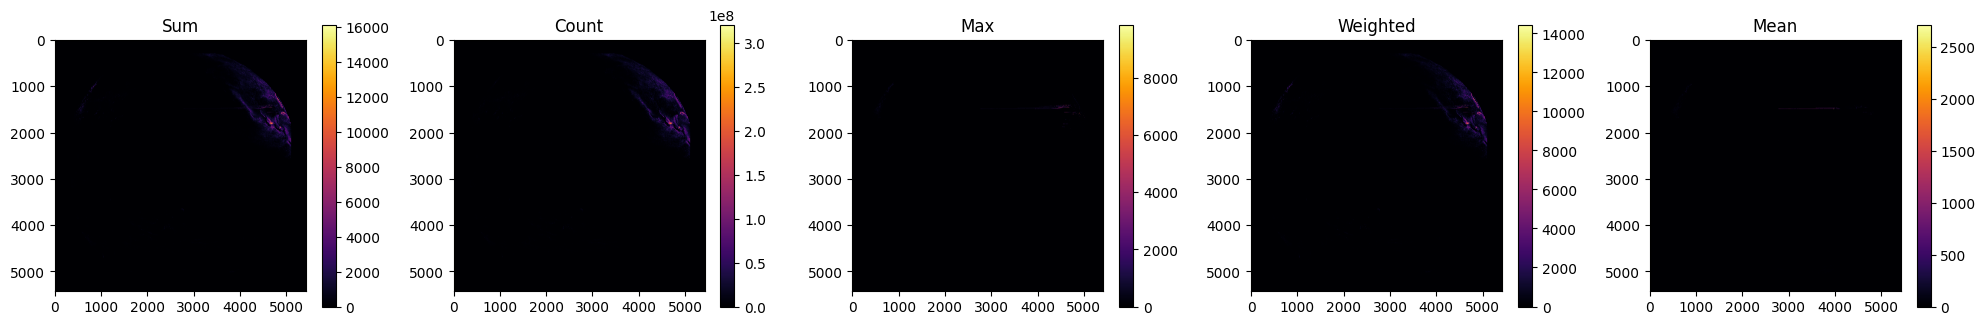


Final orbital_slot counts:
  GOES-West: 133467


In [ ]:
import os
import glob
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from collections import Counter

# === CONFIG ===
DATA_DIR = r"E:\GOES-R Lightning Data\JULY-EAST"
OUTPUT_DIR = r"E:\GOES-R Lightning Data\JULY-EAST-RASTERS"
PIXEL_SCALE = 1e5  # scale factor so small values survive GeoTIFF save
THRESHOLD = 1.2e-05

# === Metric accumulators ===
sum_raster = None
count_raster = None
max_raster = None
weighted_raster = None
mean_sum = None
mean_count = None

# === orbital_slot counter ===
slot_counter = Counter()

# === Load files ===
files = glob.glob(os.path.join(DATA_DIR, "*.nc"))

for i, f in enumerate(files, start=1):
    with Dataset(f, "r") as ds:
        # --- read orbital_slot global attribute ---
        if "orbital_slot" in ds.ncattrs():
            slot = ds.getncattr("orbital_slot")
            slot_counter[slot] += 1
        else:
            slot_counter["UNKNOWN"] += 1

        # adjust variable name if needed (GLM L2 NetCDF files)
        energy = ds.variables["Total_Optical_energy"][:].filled(0)

        # skip if all zeros
        if np.all(energy == 0):
            continue

        # initialize arrays on first pass
        if sum_raster is None:
            shape = energy.shape
            sum_raster = np.zeros(shape, dtype=np.float64)
            count_raster = np.zeros(shape, dtype=np.float64)
            max_raster = np.zeros(shape, dtype=np.float64)
            weighted_raster = np.zeros(shape, dtype=np.float64)
            mean_sum = np.zeros(shape, dtype=np.float64)
            mean_count = np.zeros(shape, dtype=np.float64)

        # --- metric 1: sum ---
        sum_raster += energy

        # --- metric 2: count flashes > threshold ---
        count_raster += (energy > THRESHOLD).astype(np.float64)

        # --- metric 3: max flash energy ---
        max_raster = np.maximum(max_raster, energy)

        # --- metric 4: weighted intensity ---
        weighted_raster += energy * (energy > THRESHOLD)

        # --- metric 5: mean optical energy above threshold ---
        mask = energy > THRESHOLD
        mean_sum += np.where(mask, energy, 0)
        mean_count += mask.astype(np.float64)

    # --- print progress every 1000 files ---
    if i % 1000 == 0:
        print(f"Processed {i} files. Orbital slot counts so far:")
        for slot, count in slot_counter.items():
            print(f"  {slot}: {count}")

# avoid division by zero
mean_raster = np.divide(mean_sum, mean_count, out=np.zeros_like(mean_sum), where=mean_count > 0)

# === Scale results ===
sum_raster *= PIXEL_SCALE
count_raster *= PIXEL_SCALE
max_raster *= PIXEL_SCALE
weighted_raster *= PIXEL_SCALE
mean_raster *= PIXEL_SCALE

# === Save rasters ===
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_raster(arr, name):
    out_path = os.path.join(OUTPUT_DIR, f"{name}.tif")
    height, width = arr.shape
    transform = from_origin(0, 0, 1, 1)  # dummy transform
    with rasterio.open(
        out_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="float32",
        crs=None,
        transform=transform,
    ) as dst:
        dst.write(arr.astype(np.float32), 1)

save_raster(sum_raster, "sum_energy")
save_raster(count_raster, "count_flashes")
save_raster(max_raster, "max_energy")
save_raster(weighted_raster, "weighted_intensity")
save_raster(mean_raster, "mean_energy")

# === Plot ===
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
titles = ["Sum", "Count", "Max", "Weighted", "Mean"]
arrays = [sum_raster, count_raster, max_raster, weighted_raster, mean_raster]

for ax, arr, title in zip(axes, arrays, titles):
    im = ax.imshow(arr, cmap="inferno")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, shrink=0.6)

plt.tight_layout()
plt.show()

# === Final orbital_slot summary ===
print("\nFinal orbital_slot counts:")
for slot, count in slot_counter.items():
    print(f"  {slot}: {count}")
